In [1]:
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import numpy as np
from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets
from scipy.stats import norm,lognorm
from itertools import permutations
from scipy import linalg,optimize

# Quelques définitions

In [146]:
class combined_distribution:
    def __init__(self,dists,weigths):
        self.dists = dists
        self.weights = weigths / weigths.sum()
        self.var_estimate = None
    
    def pdf(self,x):
        pdfs = np.array([dist.pdf(x) for dist in self.dists])
        return np.dot(self.weights,pdfs)
    
    def cdf(self,x):
        pdfs = np.array([dist.cdf(x) for dist in self.dists])
        return np.dot(self.weights,pdfs)
    
    def cdf_inv(self,u):
        res = np.array([
            optimize.minimize_scalar(lambda x: (self.cdf(x)-u_i)**2)
            for u_i in np.array([u]).ravel()])
        return np.array([res_i.x for res_i in res])
    
    def sample(self,n):
        threshold = np.cumsum(self.weights)
        draw = np.random.random(size=n)
        cum_sets = [ set(np.where( draw < threshold[i])[0]) for i in range(0,len(threshold))]
        sets = [cum_sets[0]]+[ cum_sets[i+1]-cum_sets[i] for i in range(0,len(cum_sets)-1)]
        repartition = [len(set_i) for set_i in sets]
        samples = [dist_i.ppf(np.random.rand(n_i)) for (dist_i,n_i) in zip(dists,repartition)]
        return np.concatenate(samples)
    
    def mean(self):
        means = [dist.mean() for dist in dists]
        return np.dot(self.weights,means)
    
    def median(self):
        return self.cdf_inv(0.5)
    
    def var(self):
        if self.var_estimate is None:
            samples = self.sample(1000)
            self.var_estimate = np.mean(np.square(samples)) - np.square(samples.mean())
        return self.var_estimate
    
    def std(self):
        return np.sqrt(self.var())
    
    def sample_mean_dist(self,n):
        std_estimation = self.std() / np.sqrt(n)
        return norm(loc= self.mean(),scale= std_estimation)

# Exemple de distribution

In [147]:
dists = np.array([norm(loc=-2),norm(loc=0,scale=0.5),norm(loc=4,scale=2)])
weights = np.array([3,2,5])
complex_dist = combined_distribution(dists,weights)
print("Distribution Multi-modale")
for dist,weight in zip(complex_dist.dists,complex_dist.weights):
    print("N({},{}) x {}".format(dist.mean(),dist.var(),weight))

Distribution Multi-modale
N(-2.0,1.0) x 0.3
N(0.0,0.25) x 0.2
N(4.0,4.0) x 0.5


In [148]:
print("Moyenne :",complex_dist.mean())
print("Median :",complex_dist.median())
print("Variance :",complex_dist.var())
print("Ecart-type :",complex_dist.std())

Moyenne : 1.4
Median : [0.62058499]
Variance : 9.15134623221644
Ecart-type : 3.025119209587688


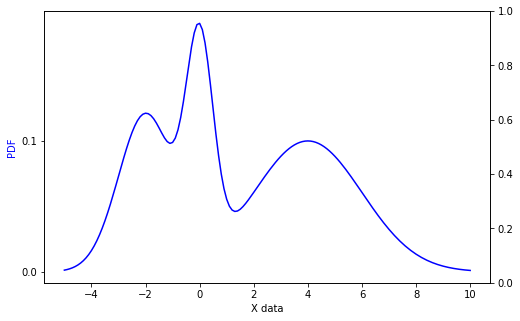

In [149]:
x = np.linspace(-5,10,151)
fig, ax1 = plt.subplots()
plt.yticks(np.arange(0,1,step=0.1))

ax2 = ax1.twinx()
ax1.plot(x, complex_dist.pdf(x), 'b-')
#ax2.plot(x, complex_dist.cdf(x), 'r-')

ax1.set_xlabel('X data')
ax1.set_ylabel('PDF', color='b')
#ax2.set_ylabel('CDF', color='r')


#ax1.plot([complex_dist.mean()]*2,[0,complex_dist.pdf(complex_dist.mean())],color='k')
#ax1.plot([complex_dist.median()]*2,[0,complex_dist.pdf(complex_dist.median())],color='k')
#for mode in [dist_i.mean() for dist_i in complex_dist.dists]:
#    ax1.plot([mode]*2,[0,complex_dist.pdf(mode)],color='k')
#ax2.plot([complex_dist.median(),x.max()],[0.5,0.5],"k--")
#ax2.plot([complex_dist.median()]*2,[0,0.5],color='k',linestyle="--")
#ax2.plot([complex_dist.cdf_inv(0.25),x.max()],[0.25,0.25],"--",color="gray")
#ax2.plot([complex_dist.cdf_inv(0.25)]*2,[0,0.25],color='gray',linestyle="--")
#ax2.plot([complex_dist.cdf_inv(0.75),x.max()],[0.75,0.75],"--",color="gray")
#ax2.plot([complex_dist.cdf_inv(0.75)]*2,[0,0.75],color='gray',linestyle="--")

fig.set_size_inches((8,5))

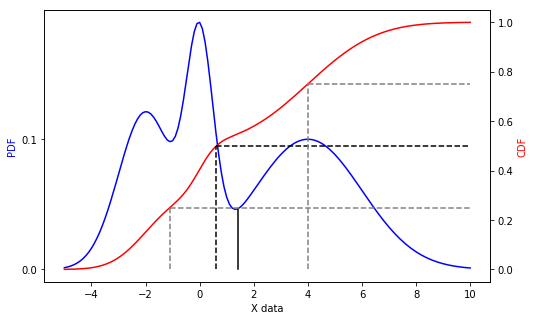

In [150]:
x = np.linspace(-5,10,151)
fig, ax1 = plt.subplots()
plt.yticks(np.arange(0,1,step=0.1))

ax2 = ax1.twinx()
ax1.plot(x, complex_dist.pdf(x), 'b-')
ax2.plot(x, complex_dist.cdf(x), 'r-')

ax1.set_xlabel('X data')
ax1.set_ylabel('PDF', color='b')
ax2.set_ylabel('CDF', color='r')


ax1.plot([complex_dist.mean()]*2,[0,complex_dist.pdf(complex_dist.mean())],color='k')
ax2.plot([complex_dist.median(),x.max()],[0.5,0.5],"k--")
ax2.plot([complex_dist.median()]*2,[0,0.5],color='k',linestyle="--")
ax2.plot([complex_dist.cdf_inv(0.25),x.max()],[0.25,0.25],"--",color="gray")
ax2.plot([complex_dist.cdf_inv(0.25)]*2,[0,0.25],color='gray',linestyle="--")
ax2.plot([complex_dist.cdf_inv(0.75),x.max()],[0.75,0.75],"--",color="gray")
ax2.plot([complex_dist.cdf_inv(0.75)]*2,[0,0.75],color='gray',linestyle="--")

fig.set_size_inches((8,5))

In [151]:
@interact(n=widgets.IntSlider(min=1,max=1000,stp=1,value=10,continuous_update=True))
def interact_sampling(n):
    sample = complex_dist.sample(n)
    
    fig, ax1 = plt.subplots()
    x = np.linspace(-5,10,151)
    ax1.set_xlim(-5,10)

    plt.yticks(np.arange(0,1,step=0.1))
    ax2 = ax1.twinx()
    ax1.set_ylim(0,0.2)
    ax2.set_ylim(0,1)

    ax1.hist(sample,density=True,bins=20,zorder=1)
    ax2.hist(sample,cumulative=True,density=True,bins=20,histtype="step",facecolor=None,edgecolor="red",zorder=0)
    ax1.plot(x, complex_dist.pdf(x), 'k--')
    ax2.plot(x, complex_dist.cdf(x), 'k--')
    
    ax1.axvline(x=complex_dist.mean(),color='green',linestyle="-",ymax=1.0)
    ax1.axvline(x=sample.mean(),color='k',linestyle="--",ymax=0.9)

    ax1.set_xlabel('X data')
    ax1.set_ylabel('PDF', color='b')
    ax2.set_ylabel('CDF', color='r')
    fig.set_size_inches((8,5))

interactive(children=(IntSlider(value=10, description='n', max=1000, min=1), Output()), _dom_classes=('widget-…

# Théorème central limite

In [154]:

@interact(n_sample=widgets.IntSlider(value=50,min=1,max=1000,step=1,continuous_update=False),
          sample_size=widgets.IntSlider(value=2,min=1,max=30,step=1,continuous_update=False))
def demo_central_limit_n(n_sample,sample_size):
    estimate = [
        complex_dist.sample(sample_size).mean()
        for i in range(n_sample)]

    x = np.linspace(-5,10,151)
    fig, ax1 = plt.subplots()
    ax1.hist(estimate,color='g',density=True,zorder=0)
    ax2= ax1.twinx()
    ax2.plot(x, complex_dist.pdf(x), 'b-',zorder=1)

    estimation_mean_dist = complex_dist.sample_mean_dist(sample_size)
    plt.axvline(x=complex_dist.mean(),color='k',linestyle="--",ymax=0.9,zorder=3)
    ax1.plot(x,estimation_mean_dist.pdf(x),color='r',zorder=2)
    ymin,ymax = plt.ylim()
    ax1.set_ylim(0,max(ymax,1.05 * estimation_mean_dist.pdf(complex_dist.mean())))


interactive(children=(IntSlider(value=50, continuous_update=False, description='n_sample', max=1000, min=1), I…

# Variance vs. Variance relative

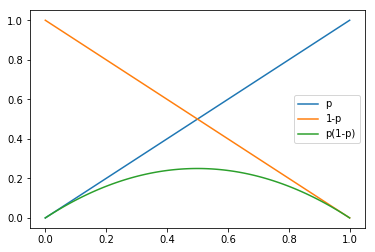

In [153]:


p = np.linspace(0,1,100)
plt.plot(p,p,label="p")
plt.plot(p,1-p,label="1-p")
plt.plot(p,np.multiply(p,1-p),label="p(1-p)")
plt.legend()

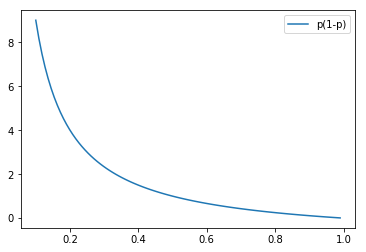

In [156]:

p = np.linspace(0.1,0.99,100)
plt.plot(p,np.multiply(1/p,1-p),label="p(1-p)")
plt.legend()

